Implementing test of getting an angle for the difference betweeen maps of the same time/area but different arrays. Only checking situations where the maps are both good by using the full set of cuts

The method is as follows: I take the difference between the estimators for the two arrays and form a chi^2 by squaring this difference (assuming a mean of zero) and dividing by 2\*covariance where the covariance is the sum of the covariances for the two arrays, then use this to calculate the chi2 survival function with df = nbins-1.

I am using the ivar weighted data with the galaxy mask implemented in angle_calc_1730955668 (from 11/07/24)

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from pixell import enmap, enplot, reproject, utils, curvedsky
from tqdm import tqdm
import pandas as pd
import nawrapper as nw
import yaml
import time
import healpy as hp
from scipy import optimize as op
import os
from scipy.stats.distributions import chi2
from itertools import combinations

In [2]:
# Loading spectra from run
spectra_dict = np.load('/home/zbh5/act_analysis/act_axion_analysis/results/angle_calc_1730955668/angle_calc_1730955668_spectra.npy',allow_pickle=True).item()

In [3]:
maps = np.array(list(spectra_dict.keys()))
n_maps = len(maps)
print(n_maps)
print(spectra_dict[maps[0]].keys())

264
dict_keys(['ell', 'E1xB2', 'E2xB1', 'E1xE1', 'B2xB2', 'E2xE2', 'B1xB1', 'E1xE2', 'B1xB2', 'E1xB1', 'E2xB2', 'binned_nu', 'estimator', 'covariance', 'CAMB_EE', 'CAMB_BB', 'w2_depth1', 'w2_cross', 'w2_ref', 'meas_angle', 'meas_errbar', 'ivar_sum', 'residual_mean', 'residual_sum', 'map_cut'])


Because this data set still has a typo in the residual_sum variable (which has already been fixed in the code and so won't affect all future data sets), I need to fix that variable for the cuts to work correctly.

In [4]:
def estimator_likelihood(angle, estimator, covariance, ClEE):
    """For a given difference in angle between the depth-1 map (map 1) and the coadd (map 2),
       returns the value of the normalized likelihood for our estimator.
       
       ClEE is the theory EE spectrum from CAMB"""

    numerator = (estimator - ClEE*np.sin(2*angle))**2
    denominator = 2*covariance
    likelihood = np.exp(-np.sum(numerator/denominator))
    return likelihood

def gaussian(x,mean,sigma):
    """Normalized Gaussian for curve_fit"""
    amp = 1.0
    return amp*np.exp(-(x-mean)**2/(2*sigma**2))

def gaussian_fit_curvefit(angles,data):
    """
        Uses scipy.optimize.curve_fit() to fit a Gaussian to the likelihood to
        get the mean and standard deviation.

        Assumes everything is in radians.
    """
    guess = [1.0*np.pi/180.0, 5.0*np.pi/180.0] # Mean=1, stddev=5 worked well for 73 test maps
    popt, pcov = op.curve_fit(gaussian,angles,data,guess,maxfev=50000)
    mean = popt[0]
    std_dev = np.abs(popt[1])
    return mean, std_dev

def sample_likelihood_and_fit(estimator,covariance,theory_ClEE,angle_min_deg=-20.0,angle_max_deg=20.0,
                              num_pts=10000,use_curvefit=True,plot_like=False,output_dir=None,map_fname=None):
    """
       Samples likelihood for a range of angles and returns the best fit for the
       mean and std dev of the resulting Gaussian in degrees.  
       Has the option to do the fitting with scipy.optimize.curve_fit() (set use_curvefit=True)
       or a method using moments of the Gaussian. The moments method is faster but less
       accurate when the likelihood deviates from Gaussianity in any way.
    """
    if(angle_min_deg >= angle_max_deg): 
        raise ValueError("The min angle must be smaller than the max!")
    angles_deg = np.linspace(angle_min_deg,angle_max_deg,num=num_pts)
    angles_rad = np.deg2rad(angles_deg)
    
    bin_sampled_likelihood = [estimator_likelihood(angle,estimator,covariance,theory_ClEE) for angle in angles_rad]
    norm_sampled_likelihood = bin_sampled_likelihood/np.max(bin_sampled_likelihood)
    
    if use_curvefit:
        fit_values = gaussian_fit_curvefit(angles_rad,norm_sampled_likelihood)
        fit_values_deg = [np.rad2deg(fit_values[0]), np.rad2deg(fit_values[1])]
        # Could add some flag or option to redo the fit for a given map if curve_fit() returns
        # a bad stddev value from failing to fit - for now I will leave it so I can see easily by the stddev that it fails
    else:
        fit_values = gaussian_fit_moment(angles_rad,norm_sampled_likelihood)
        fit_values_deg = [np.rad2deg(fit_values[0]), np.rad2deg(fit_values[1])]

    # Calculating mean and sum of abs of residual between likelihood and best fit Gaussian
    # within 1 sigma of mean value - two possible ways of identifying and cutting poor S/N or bad fits
    residual = norm_sampled_likelihood - gaussian(angles_rad,fit_values[0],fit_values[1])
    minus_sigma_idx = np.searchsorted(angles_rad, fit_values[0]-fit_values[1])
    plus_sigma_idx = np.searchsorted(angles_rad, fit_values[0]+fit_values[1])
    residual_mean = np.mean(residual[minus_sigma_idx:plus_sigma_idx])
    residual_sum = np.sum(np.abs(residual[minus_sigma_idx:plus_sigma_idx]))

    if plot_like:
        map_name = os.path.split(map_fname)[1][:-9] # removing "_map.fits"
        plot_likelihood(output_dir, map_name, angles_deg, norm_sampled_likelihood,fit_values_deg,residual)

    return fit_values_deg, residual_mean, residual_sum

In [5]:
test_CAMB_EE = spectra_dict[maps[0]]['CAMB_EE']
residual_sums_corr = 9999*np.ones(n_maps)
residual_means_corr = 9999*np.ones(n_maps)

map_nums = np.arange(n_maps)
for map_num in map_nums:
    if spectra_dict[maps[map_num]]['map_cut'] != 1:
        results,res_mean,res_sum = sample_likelihood_and_fit(spectra_dict[maps[map_num]]['estimator'],
                                                     spectra_dict[maps[map_num]]['covariance'],
                                                     test_CAMB_EE,angle_min_deg=-50.0,
                                    angle_max_deg=50.0,num_pts=200000,plot_like=False,map_fname='map '+str(map_num))
        residual_sums_corr[map_num] = res_sum
        residual_means_corr[map_num] = res_mean

/home/zbh5/anaconda3/envs/act_analysis/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/zbh5/anaconda3/envs/act_analysis/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [7]:
# Investigating trends in residual_sum_corr
#plt.plot(residual_sums_corr)
#plt.title("Sum of Gaussian residuals to likelihood within 1 sigma")
#plt.ylabel("Residual sum corrected")
#plt.xlabel("Map index in list")
#plt.show()
#plt.close()

In [11]:
# Implementing automatic data cuts
cut_flags = np.zeros(n_maps)
ivar_sums = np.zeros(n_maps)
all_errbars = np.zeros(n_maps)
for i in range(n_maps):
    cut_flags[i] = spectra_dict[maps[i]]['map_cut']
    all_errbars[i] = spectra_dict[maps[i]]['meas_errbar']
    ivar_sums[i] = spectra_dict[maps[i]]['ivar_sum']
    #residual_sums[i] = spectra_dict[maps[i]]['residual_sum'] # DON'T USE THIS HERE - use residual_sums_corr!

print("Total number of maps: ", n_maps)
# Identifying maps that weren't cut by the galaxy mask
cut_good = np.where(cut_flags != 1)[0]
print("Maps passing galaxy mask cut: ", len(cut_good))
# Using the super small errorbars to identify the failed fits
errbar_good = np.where(all_errbars>0.1)[0]
print("Maps passing bad fit cut: ", len(errbar_good))
# Using residual cutoff of 1500
residual_good = np.where(residual_sums_corr<1500)[0]
print("Maps passing residual cut: ", len(residual_good))
# Using ivar cutoff of 1.5
ivar_good = np.where(ivar_sums>1.5)[0]
print("Maps passing ivar cut: ", len(ivar_good))
# Taking the intersection of these four sets to get those maps that pass all cuts
set_pass_all_cuts = np.intersect1d(np.intersect1d(np.intersect1d(cut_good,errbar_good),residual_good),ivar_good)
print("Maps passing all four cuts: ", len(set_pass_all_cuts))
print(set_pass_all_cuts)

Total number of maps:  264
Maps passing galaxy mask cut:  256
Maps passing bad fit cut:  247
Maps passing residual cut:  181
Maps passing ivar cut:  202
Maps passing all four cuts:  166
[  0   1   2   6   7   8  10  18  19  20  21  22  23  24  25  26  27  28
  29  30  37  38  39  47  48  49  51  56  57  58  59  60  61  62  63  64
  66  67  68  69  70  71  72  73  74  75  76  78  79  80  81  82  83  84
  85  86  87  88  89  90  91  92  93  94  96  97  98  99 100 102 104 105
 112 113 114 115 116 117 118 119 120 121 122 123 128 130 131 132 134 136
 137 141 142 143 144 145 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 173 174 175 176 177 179 180 181 182 183 185 186 187 189 190
 193 195 196 197 198 199 200 201 202 203 204 205 206 210 211 212 213 217
 218 219 221 222 224 225 227 228 231 232 233 243 244 245 247 250 251 254
 255 258 259 263]


In [56]:
# Extracting map info and results into separate arrays for ease of access
map_arrays = []
map_timestamps = []
estimators = []
covariances = []

for i in range(n_maps):
    map_arrays.append(maps[i].split('_')[2])
    map_timestamps.append(maps[i].split('_')[1])
    estimators.append(spectra_dict[maps[i]]['estimator'])
    covariances.append(spectra_dict[maps[i]]['covariance'])
map_arrays = np.array(map_arrays)
map_timestamps = np.array(map_timestamps)
estimators = np.array(estimators)
covariances = np.array(covariances)

In [13]:
good_maps = np.array(maps[set_pass_all_cuts])
print("Total number of maps passing cuts: ", len(good_maps))
good_timestamps = np.array([m.split('_')[1] for m in good_maps])
unique_good_timestamps = np.unique(good_timestamps)
print("Number of unique timestamps that pass cuts: ", len(unique_good_timestamps))

Total number of maps passing cuts:  166
Number of unique timestamps that pass cuts:  69


In [57]:
print(unique_good_timestamps[3])
print(good_timestamps[0:10])
indices = set_pass_all_cuts[np.where(good_timestamps==unique_good_timestamps[1])[0]]
print(indices)
print(map_arrays[indices])

1494726991
['1494463440' '1494463440' '1494463440' '1494479992' '1494479992'
 '1494479992' '1494565020' '1494726991' '1494735603' '1494735603']
[6 7 8]
['pa4' 'pa5' 'pa6']


In [63]:
# Generating a list of all pairs of indices that need to be processed
# Also makes a list of strings showing which arrays each pair goes with for easy counting
all_pairs = []
all_pairs_array_tags = []
for timestamp in unique_good_timestamps:
    indices = set_pass_all_cuts[np.where(good_timestamps==timestamp)[0]] # Getting indices from full list
    if len(indices)>1:
        pairs = [comb for comb in combinations(indices,r=2)]
        for pair in pairs:
            all_pairs.append(pair)
            all_pairs_array_tags.append(map_arrays[pair[0]]+map_arrays[pair[1]])
all_pairs = np.array(all_pairs)
all_pairs_array_tags = np.array(all_pairs_array_tags)

In [81]:
# Getting indices within all_pairs for each set of arrays
pa4pa5_indices = np.where(all_pairs_array_tags=='pa4pa5')[0]
pa4pa6_indices = np.where(all_pairs_array_tags=='pa4pa6')[0]
pa5pa6_indices = np.where(all_pairs_array_tags=='pa5pa6')[0]
print(type(pa4pa5_indices))

<class 'numpy.ndarray'>


In [77]:
print("Total number of array difference pairs: ", len(all_pairs))
print("Total number of array tags: ", len(all_pairs_array_tags))
print("Number of pa4-pa5 pairs: ", pa4pa5_indices.size)
print("Number of pa4-pa6 pairs: ", pa4pa6_indices.size)
print("Number of pa5-pa6 pairs: ", pa5pa6_indices.size)

Total number of array difference pairs:  137
Total number of array tags:  137
Number of pa4-pa5 pairs:  44
Number of pa4-pa6 pairs:  40
Number of pa5-pa6 pairs:  53


In [71]:
estimators[all_pairs[10][0]]

array([-1.40473031e-05,  1.60604091e-04,  4.14370645e-06, -3.02660071e-05,
       -9.88406252e-06, -7.30972741e-05, -5.57111347e-05,  3.15224974e-05,
        9.30771131e-06, -3.57261525e-05])

In [87]:
# Forming chi-squared and calculating PTE for each pair
chi2_all_pairs = []
pte_all_pairs = []

for pair in all_pairs:
    est_diff = estimators[pair[0]] - estimators[pair[1]]
    cov_sum = covariances[pair[0]] + covariances[pair[1]]
    chi2_pair = np.sum(est_diff**2/(2*cov_sum)) # Assuming expected value of zero for difference of estimators
    dof_pair = est_diff.size - 1 # Should be same each time
    pte_pair = chi2.sf(chi2_pair,dof_pair)
    chi2_all_pairs.append(chi2_pair)
    pte_all_pairs.append(pte_pair)
chi2_all_pairs = np.array(chi2_all_pairs)
pte_all_pairs = np.array(pte_all_pairs)

In [83]:
pte_all_pairs[pa4pa5_indices]

array([0.60713493, 0.81253127, 0.77973287, 0.60437066, 0.32001988,
       0.2932067 , 0.73633867, 0.6893867 , 0.76455034, 0.84552196,
       0.97574272, 0.92673488, 0.65536314, 0.90789314, 0.93474295,
       0.07314648, 0.55717846, 0.63300236, 0.93229724, 0.86661424,
       0.82795876, 0.51138498, 0.84149588, 0.73454799, 0.55210009,
       0.76876367, 0.78716698, 0.52751057, 0.58362844, 0.66711664,
       0.03064017, 0.97861929, 0.03621825, 0.94045519, 0.93527711,
       0.99037182, 0.95694983, 0.73911809, 0.89826536, 0.56423328,
       0.67126819, 0.75164758, 0.63031691, 0.45164436])

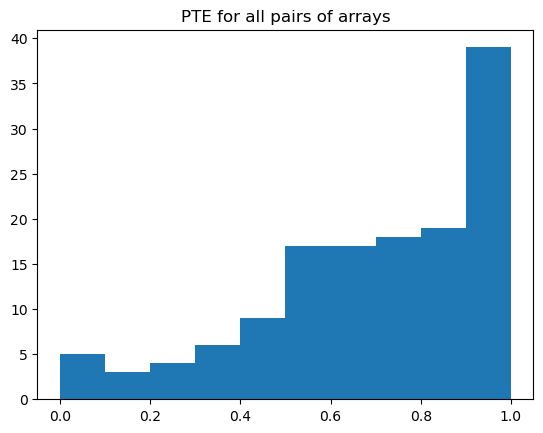

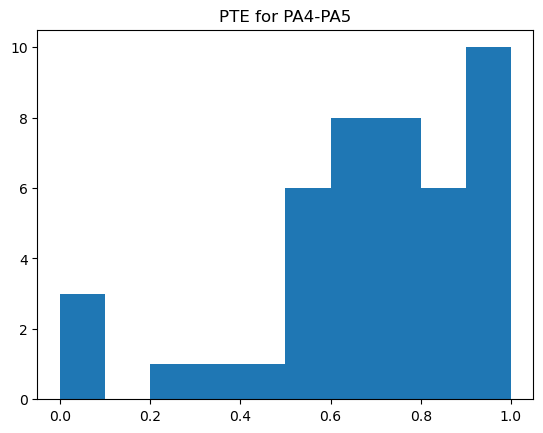

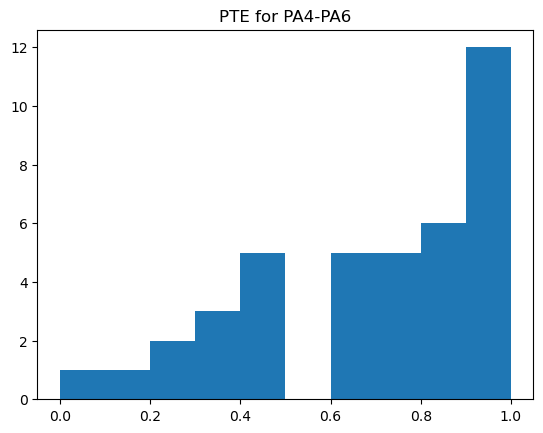

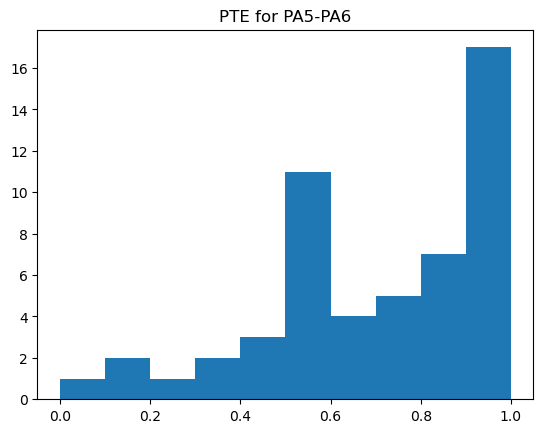

In [91]:
# Making PTE distribution plots 

# All pairs
plt.hist(pte_all_pairs,bins=10,range=(0.0,1.0))
plt.title("PTE for all pairs of arrays")
plt.show()
plt.close()

# PA4-PA5
plt.hist(pte_all_pairs[pa4pa5_indices],bins=10,range=(0.0,1.0))
plt.title("PTE for PA4-PA5")
plt.show()
plt.close()

# PA4-PA6
plt.hist(pte_all_pairs[pa4pa6_indices],bins=10,range=(0.0,1.0))
plt.title("PTE for PA4-PA6")
plt.show()
plt.close()

# PA5-PA6
plt.hist(pte_all_pairs[pa5pa6_indices],bins=10,range=(0.0,1.0))
plt.title("PTE for PA5-PA6")
plt.show()
plt.close()

In [93]:
maps[all_pairs[pa5pa6_indices]]

array([['depth1_1494463440_pa5_f150_map.fits',
        'depth1_1494463440_pa6_f150_map.fits'],
       ['depth1_1494479992_pa5_f150_map.fits',
        'depth1_1494479992_pa6_f150_map.fits'],
       ['depth1_1494735603_pa5_f150_map.fits',
        'depth1_1494735603_pa6_f150_map.fits'],
       ['depth1_1494743515_pa5_f150_map.fits',
        'depth1_1494743515_pa6_f150_map.fits'],
       ['depth1_1494761700_pa5_f150_map.fits',
        'depth1_1494761700_pa6_f150_map.fits'],
       ['depth1_1513422389_pa5_f150_map.fits',
        'depth1_1513422389_pa6_f150_map.fits'],
       ['depth1_1513445778_pa5_f150_map.fits',
        'depth1_1513445778_pa6_f150_map.fits'],
       ['depth1_1513481732_pa5_f150_map.fits',
        'depth1_1513481732_pa6_f150_map.fits'],
       ['depth1_1513948346_pa5_f150_map.fits',
        'depth1_1513948346_pa6_f150_map.fits'],
       ['depth1_1513997690_pa5_f150_map.fits',
        'depth1_1513997690_pa6_f150_map.fits'],
       ['depth1_1514032657_pa5_f150_map.fits',
   